In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv'

In [12]:
df = pd.read_csv('AirBnB.csv')

<AxesSubplot:xlabel='price', ylabel='Count'>

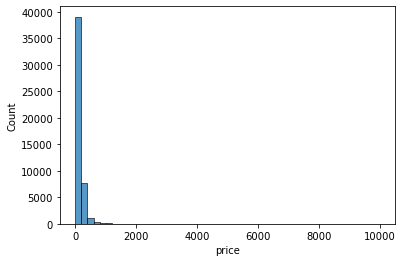

In [11]:
# EDA
sns.histplot(df['price'], bins=50)

In [14]:
columns = ['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

df = df[columns]
df.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,40.64749,-73.97237,149,1,9,0.21,6,365
1,40.75362,-73.98377,225,1,45,0.38,2,355
2,40.80902,-73.94190,150,3,0,NaN,1,365
3,40.68514,-73.95976,89,1,270,4.64,1,194
4,40.79851,-73.94399,80,10,9,0.10,1,0


In [16]:
df.isnull().sum()

latitude                              0
longitude                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [18]:
df['minimum_nights'].median()

3.0

### Split the data
### Shuffle the initial dataset, use seed 42.
### Split your data in train/val/test sets, with 60%/20%/20% distribution.
### Make sure that the target value ('price') is not in your dataframe.
### Apply the log transformation to the price variable using the np.log1p() function.

In [54]:
n = len(df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_val['price']
del df_test['price']

### Question 3
### We need to deal with missing values for the column from Q1.
### We have two options: fill it with 0 or with the mean of this variable.
### Try both options. For each, train a linear regression model without regularization using the code from the lessons.
### For computing the mean, use the training only!
### Use the validation dataset to evaluate the models and compare the RMSE of each option.
### Round the RMSE scores to 2 decimal digits using round(score, 2)
### Which option gives better RMSE?

In [55]:
def train_lin_reg(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

def rmse(y, y_pred):
    se = (y-y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

base = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']


In [56]:
# Replace with 0
# Train
X_train_0 = df_train[base].fillna(0).values
w0, w = train_lin_reg(X_train_0, y_train)
# Validate
X_val_0 = df_val[base].fillna(0).values
y_pred = w0 + X_val_0.dot(w)
score = rmse(y_val, y_pred)
print(round(score, 2))

0.64


In [57]:
# Replace with mean
# Train
X_train_mean = df_train[base].fillna(df_train['reviews_per_month'].mean()).values
w0, w = train_lin_reg(X_train_mean, y_train)
# Validate
X_val_mean = df_val[base].fillna(df_train['reviews_per_month'].mean()).values
y_pred = w0 + X_val_mean.dot(w)
score = rmse(y_val, y_pred)
print(round(score, 2))

0.64


In [58]:
df_train.mean()

latitude                           40.729226
longitude                         -73.951838
minimum_nights                      6.989740
number_of_reviews                  23.312336
reviews_per_month                   1.368549
calculated_host_listings_count      7.125166
availability_365                  112.825988
dtype: float64

Question 4
* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0.
* Try different values of r from this list: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10].
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which r gives the best RMSE?
* If there are multiple options, select the smallest r.

In [59]:
def train_lin_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [60]:
for R in [0.0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    # Training part
    X_train = df_train[base].fillna(0).values
    w0, w = train_lin_reg(X_train, y_train, r=R)

    # Validation part
    X_val = df_val[base].fillna(0).values
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    print(R, w0, round(score, 2))

0.0 -419.9126602782961 0.64
1e-06 -419.8627175018098 0.64
0.0001 -414.97649420185604 0.64
0.001 -375.2736539367924 0.64
0.01 -191.78384091255427 0.66
0.1 -32.56256056402253 0.68
1 -3.4992168400821244 0.68
5 -0.7033623161458142 0.68
10 -0.35127675971367145 0.68


Question 5
* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
* What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
* Round the result to 3 decimal digits (round(std, 3))

In [61]:
def train_lin_reg(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

scores = []

for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)

    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    y_train = np.log1p(df_train.price.values)
    y_val = np.log1p(df_val.price.values)
    y_test = np.log1p(df_test.price.values)

    del df_train['price']
    del df_val['price']
    del df_test['price']
    
    # Replace with 0
    # Train
    X_train_0 = df_train[base].fillna(0).values
    w0, w = train_lin_reg(X_train_0, y_train)
    # Validate
    X_val_0 = df_val[base].fillna(0).values
    y_pred = w0 + X_val_0.dot(w)
    score = rmse(y_val, y_pred)
    print(seed, round(score, 2))
    scores.append(round(score, 2))
    
print(round(np.std(scores), 3))

0 0.65
1 0.65
2 0.65
3 0.64
4 0.64
5 0.63
6 0.63
7 0.65
8 0.65
9 0.64
0.008


Question 6
* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with r=0.001.
* What's the RMSE on the test dataset?

In [63]:
def train_lin_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

idx = np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_val['price']
del df_test['price']

df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop=True)
X_full_train = df_full_train[base].fillna(0).values
y_full_train = np.concatenate([y_train, y_val])
w0, w = train_lin_reg(X_full_train, y_full_train, r=0.001)

X_test = df_test[base].fillna(0).values
y_pred = w0 + X_test.dot(w)
score = rmse(y_test, y_pred)
score

    


0.6452771348323516